<h1>Extract data from EMODnet sources</h1>
<ol>
    <li>Aquaculture sites for finfish and shellfish farms</li>
    <li> Marine Protected areas</li>
    <li> Plastic monitoring</li>
</ol>

In [1]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cm
import geopandas as gpd
import cartopy.feature as cfeature
import settings
import fiona
import pandas as pd
from shapely.geometry import Polygon

<h3> 1. Aquaculture sites</h3>

In [2]:
def get_dataset(file):
    return gpd.read_file(file)

In [3]:
    #bounding box for farms
top_lat, bottom_lat = 46, 30
left_lon, right_lon = -7, 37

In [4]:
def get_relevant_locations(locations):
    lat = []
    lon = []

    for i in range(len(locations)):
        if locations[i] is not None:
            lon.append(locations[i].x)
            lat.append(locations[i].y)

    lat = np.array(lat)
    lon = np.array(lon)
    # filter mediterranean region points only- get indexes first

    ids = np.where(np.logical_and(np.logical_and(lat >= bottom_lat, lat <= top_lat), np.logical_and(lon >= left_lon, lon <= right_lon)))[0]
    return lat[ids], lon[ids], ids

In [5]:
def get_dataframe(file, layer):
    gdf = gpd.read_file(file, layer=layer)
    return pd.DataFrame(gdf.values, columns=gdf.columns)

<h4>Shellfish data processing</h4> 
Data downloaded from EMODnet Human activities portal: 
<a href="https://www.emodnet-humanactivities.eu/search-results.php?dataname=Shellfish+Production">Link</a>

In [6]:
shellfish_file = settings.workspace_data_direc +"EMODnet_HA_Aquaculture_Shellfish_20191126/EMODnet_HA_Aquaculture_Shellfish_20191126.gdb"
sf_data = get_dataset(shellfish_file)
sf_lats,sf_lons, sf_index = get_relevant_locations(sf_data.geometry)
print(len(sf_index))

417


<h4>Finfish data processing</h4>
Data downloaded from EMODnet Human activities portal: 
<a href="https://www.emodnet-humanactivities.eu/search-results.php?dataname=Finfish+Production">Link</a>

In [7]:
finfish_file = settings.workspace_data_direc +"EMODnet_HA_Aquaculture_Marine_Finfish_20210913/EMODnet_HA_Aquaculture_Marine_Finfish_20210913.gdb"

layers = fiona.listlayers(finfish_file)

location_df = get_dataframe(finfish_file,layers[1])

ff_lats,ff_lons, ff_index = get_relevant_locations(location_df.geometry)
print(len(ff_index))

357


<h5>Plot both farm locations</h5> 

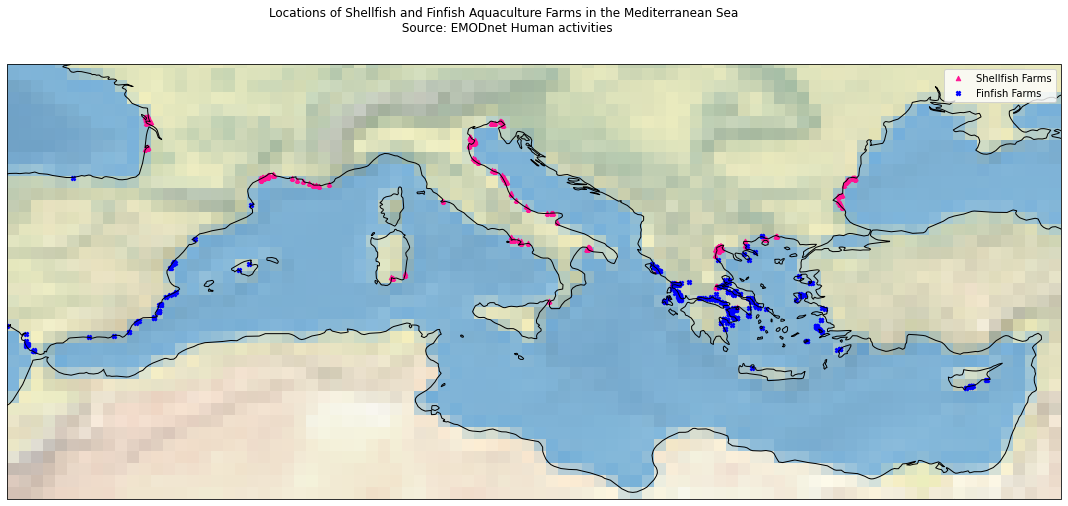

In [8]:
fig = plt.figure(figsize=(32,8))
Map_BOUNDS = [left_lon, right_lon, top_lat, bottom_lat]
plt.suptitle(
    "Locations of Shellfish and Finfish Aquaculture Farms in the Mediterranean Sea \n Source: EMODnet Human activities")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.stock_img()
ax.set_extent(Map_BOUNDS)

ax.scatter(sf_lons, sf_lats, s=20, c='deeppink', marker="^", label='Shellfish Farms')
ax.scatter(ff_lons, ff_lats, s=20, c='blue', marker='X', label='Finfish Farms')
plt.legend()
plt.show()

<h3>2. Marine Protected Areas</h3>
Data on Natura 2000 sites downloaded from EMODnet human-activities sites: <a href="https://www.emodnet-humanactivities.eu/search-results.php?dataname=Natura+2000">Link</a>

In [ ]:
gdb_file = settings.workspace_data_direc + "EMODnet_HA_Environment_Natura2000_end2020_20210909/EMODnet_HA_Environment_Natura2000_end2020_20210909.gdb"

full_data = gpd.read_file(gdb_file, bbox=(left_lon, bottom_lat, right_lon, top_lat))
data = full_data[full_data.COAST_MAR == 1]
shapes = data.geometry

In [ ]:
fig = plt.figure(figsize=(32,8))
Map_BOUNDS = [-7, 37, 46, 30]
plt.suptitle(
    "Natura 2000 sites in the Mediterranean Sea\n Source: EMODnet Human Activities")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.stock_img()
ax.set_extent(Map_BOUNDS)


def plot_mpa(shape):
    for geom in shape.geoms:
        xs, ys = Polygon(geom).exterior.coords.xy
        ax.fill(xs, ys, c="red", alpha=0.8, edgecolor='k', linewidth=0.2)


[plot_mpa(s) for s in shapes]

plt.show()

<h3>Plastic Monitoring</h3>
Data downloaded from Blue-Cloud

In [ ]:
plastic_file = settings.workspace_data_direc + "PlasticBags_MedSea/bl_plasticbags_other.shp"

layers = fiona.listlayers(plastic_file)

location_df = get_dataframe(plastic_file,layers[0])

pl_lats,pl_lons, pl_index = get_relevant_locations(location_df.geometry)
print(len(pl_index))

In [ ]:
fig = plt.figure(figsize=(32,8))
Map_BOUNDS = [left_lon, right_lon, top_lat, bottom_lat]
plt.suptitle(
    "Locations of Plastic Litter observation in the Mediterranean Sea\n Source: EMODnet Chemistry")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND)
# ax.stock_img()
ax.set_extent(Map_BOUNDS)
ax.gridlines(draw_labels=True)

plt.scatter(pl_lons, pl_lats, c=np.float32(location_df['litterabun'][pl_index]), cmap=cm.cool, s=200,marker='o', 
            norm=clr.LogNorm(), alpha=0.8)
cbar=plt.colorbar()
cbar.set_label("Litter abundance(Log)")
# pyplot.clim(32, 37)
plt.show()